<a href="https://colab.research.google.com/github/nkokic/DeepLearning/blob/main/DU-LV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [6]:
# @title
!pip install medmnist

In [25]:
import medmnist
from medmnist import BloodMNIST

import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download and load the BloodMNIST dataset
train_dataset = BloodMNIST(split='train', download=True, as_rgb=True, size=28, transform=transform)
test_dataset = BloodMNIST(split='test', download=True, as_rgb=True, size=28, transform=transform)
val_dataset = BloodMNIST(split='val', download=True, as_rgb=True, size=28, transform=transform)

print("BloodMNIST datasets downloaded and loaded.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

BloodMNIST datasets downloaded and loaded.
Train dataset size: 11959
Test dataset size: 3421
Validation dataset size: 1712


/tmp/ipython-input-64574782.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


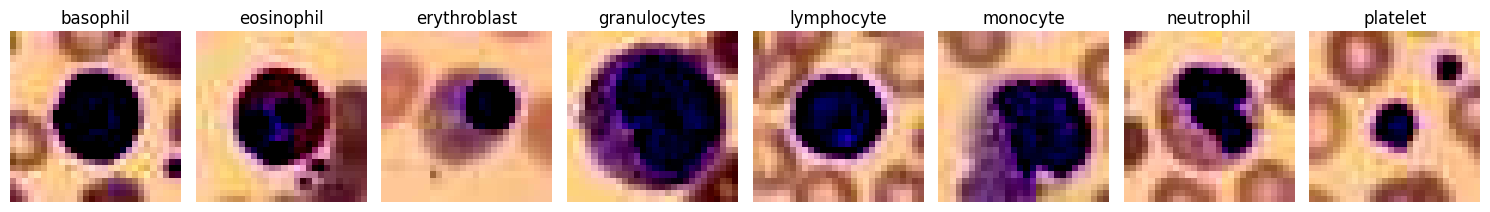

In [26]:
# Show image examples of every class
num_classes = len(train_dataset.info['label'])
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

class_to_image = {}
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label = int(label)
    if label not in class_to_image:
        class_to_image[label] = image
    if len(class_to_image) == num_classes:
        break

# Update class label for display
# train_dataset.info['label']['3'] = 'granulocytes'
# val_dataset.info['label']['3'] = 'granulocytes'
# test_dataset.info['label']['3'] = 'granulocytes'

for i in range(num_classes):
    axes[i].imshow(class_to_image[i].permute(1, 2, 0))
    axes[i].set_title(train_dataset.info['label'][str(i)])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Show count for every class in the whole data set
all_labels = []
for dataset in [train_dataset, test_dataset, val_dataset]:
    all_labels.extend([int(label) for _, label in dataset])

class_counts = np.bincount(all_labels)

print("Class counts in the whole dataset:")
for i in range(len(class_counts)):
    print(f"Class {i} ({train_dataset.info['label'][str(i)]}): {class_counts[i]}")

/tmp/ipython-input-184997941.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.extend([int(label) for _, label in dataset])


Class counts in the whole dataset:
Class 0 (basophil): 1218
Class 1 (eosinophil): 3117
Class 2 (erythroblast): 1551
Class 3 (granulocytes): 2895
Class 4 (lymphocyte): 1214
Class 5 (monocyte): 1420
Class 6 (neutrophil): 3329
Class 7 (platelet): 2348


## Define the cnn model

### Subtask:
Create a simple and customizable CNN model using PyTorch.


**Reasoning**:
Define the `SimpleCNN` class with convolutional, pooling, and fully connected layers, and then instantiate it and move it to the appropriate device.



In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=32 * 7 * 7, out_features=num_classes) # Assuming input size is 28x28

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7) # Flatten the output
        x = self.fc(x)
        return x

# Instantiate the model and move it to the device
num_classes = len(train_dataset.info['label'])
model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=1568, out_features=8, bias=True)
)


In [11]:
import torch.optim as optim

# Define loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")
print(f"Train loader has {len(train_loader)} batches.")
print(f"Test loader has {len(test_loader)} batches.")
print(f"Validation loader has {len(val_loader)} batches.")

DataLoaders created.
Train loader has 187 batches.
Test loader has 54 batches.
Validation loader has 27 batches.


In [18]:
def train_model(model, optimizer, train_data_loader, val_data_loader, loss_module, num_epochs=100, patience=10, min_delta=0.001):
    # Set model to train mode
    model.train()

    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            data_labels = data_labels.squeeze()

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

        ## Calculate loss and accuracy for both datasets
        ## Store the accuracies and losses for both datasets
        at, lt = eval_model(model, train_data_loader, loss_module)
        av, lv = eval_model(model, val_data_loader, loss_module)

        loss_train.append(lt)
        loss_val.append(lv)
        acc_train.append(at)
        acc_val.append(av)
        model.train()

        # Early stopping
        if lv < best_val_loss - min_delta:
            best_val_loss = lv
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    return loss_train, loss_val, acc_train, acc_val

In [14]:
def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    ## Calculate loss for the whole dataset
    loss_run = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            data_labels = data_labels.squeeze()
            preds = model(data_inputs)
            _, pred_labels = torch.max(preds.data, dim=1) # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]
            loss = loss_module(preds, data_labels)
            loss_run += loss.item() * data_labels.size(0)

    acc = true_preds / num_preds
    loss_run /= len(data_loader.dataset)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    print(f"Loss of the model: {loss_run}")

    return acc, loss_run

In [15]:
def visualize_training(train_loss, val_loss, train_acc, val_acc):
  plt.figure(figsize=[4,3])
  plt.plot(train_loss,'r',linewidth=1.0)
  plt.plot(val_loss,'b',linewidth=1.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[4,3])
  plt.plot(train_acc,'r',linewidth=1.0)
  plt.plot(val_acc,'b',linewidth=1.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 92.43%
Loss of the model: 0.21137660419460483
Accuracy of the model: 90.19%
Loss of the model: 0.2756209362333066


Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 93.28%
Loss of the model: 0.19742868508879122
Accuracy of the model: 90.30%
Loss of the model: 0.26808677460545693


Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 92.68%
Loss of the model: 0.20941356566974237
Accuracy of the model: 90.13%
Loss of the model: 0.27619570103761193


Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 93.80%
Loss of the model: 0.1787139376747996
Accuracy of the model: 91.41%
Loss of the model: 0.2584332911489166


Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 93.95%
Loss of the model: 0.17422417099035867
Accuracy of the model: 91.24%
Loss of the model: 0.2576967637951129


Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 94.24%
Loss of the model: 0.17243694597083456
Accuracy of the model: 91.24%
Loss of the model: 0.2579862641118397


Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 94.50%
Loss of the model: 0.1578601516153374
Accuracy of the model: 91.82%
Loss of the model: 0.25346587528692227


Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.23%
Loss of the model: 0.14421964829079092
Accuracy of the model: 91.53%
Loss of the model: 0.24344603397021783


Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.10%
Loss of the model: 0.13988959702553083
Accuracy of the model: 91.76%
Loss of the model: 0.24960874243874417


Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.05%
Loss of the model: 0.1400337311082465
Accuracy of the model: 91.41%
Loss of the model: 0.2592928277276387


Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.39%
Loss of the model: 0.13163886331218033
Accuracy of the model: 92.41%
Loss of the model: 0.24783960416495243


Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 96.14%
Loss of the model: 0.11397456804070646
Accuracy of the model: 92.41%
Loss of the model: 0.2317306311609589


Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 96.10%
Loss of the model: 0.11740325909886375
Accuracy of the model: 92.11%
Loss of the model: 0.24043774173081478


Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 96.06%
Loss of the model: 0.11463306994130754
Accuracy of the model: 91.53%
Loss of the model: 0.25968747453711855


Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.63%
Loss of the model: 0.11568248433426417
Accuracy of the model: 91.94%
Loss of the model: 0.25436513947549266


Epoch 16:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 96.81%
Loss of the model: 0.09515399617842382
Accuracy of the model: 92.11%
Loss of the model: 0.24974660714653052


Epoch 17:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 96.80%
Loss of the model: 0.09640651947031134
Accuracy of the model: 91.59%
Loss of the model: 0.25408857991205197


Epoch 18:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 97.28%
Loss of the model: 0.08581580760806129
Accuracy of the model: 92.41%
Loss of the model: 0.2535626338185551


Epoch 19:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 97.53%
Loss of the model: 0.07869436197996499
Accuracy of the model: 92.41%
Loss of the model: 0.24862841279985748


Epoch 20:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 97.47%
Loss of the model: 0.08094344472272588
Accuracy of the model: 91.71%
Loss of the model: 0.256660022189684


Epoch 21:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 98.15%
Loss of the model: 0.06414268911196362
Accuracy of the model: 92.23%
Loss of the model: 0.25317614504667085


Epoch 22:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 97.32%
Loss of the model: 0.08021377623442554
Accuracy of the model: 92.11%
Loss of the model: 0.2653910482876769
Early stopping triggered after 22 epochs.


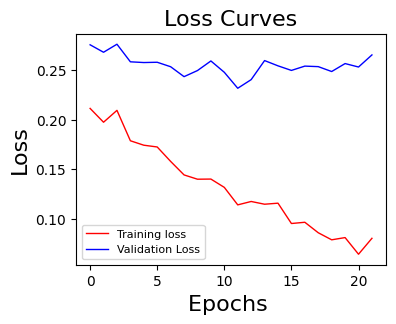

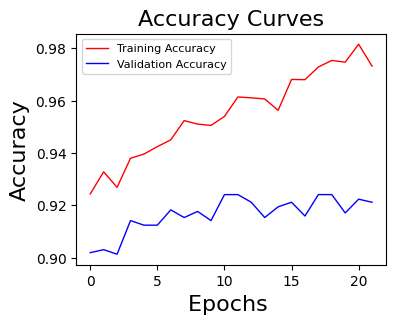

In [19]:
train_loss, val_loss, train_acc, val_acc = train_model(model, optimizer, train_loader, val_loader, loss, 100)
visualize_training(train_loss, val_loss, train_acc, val_acc)

Accuracy of the model on the 3421 test images: 91.35%


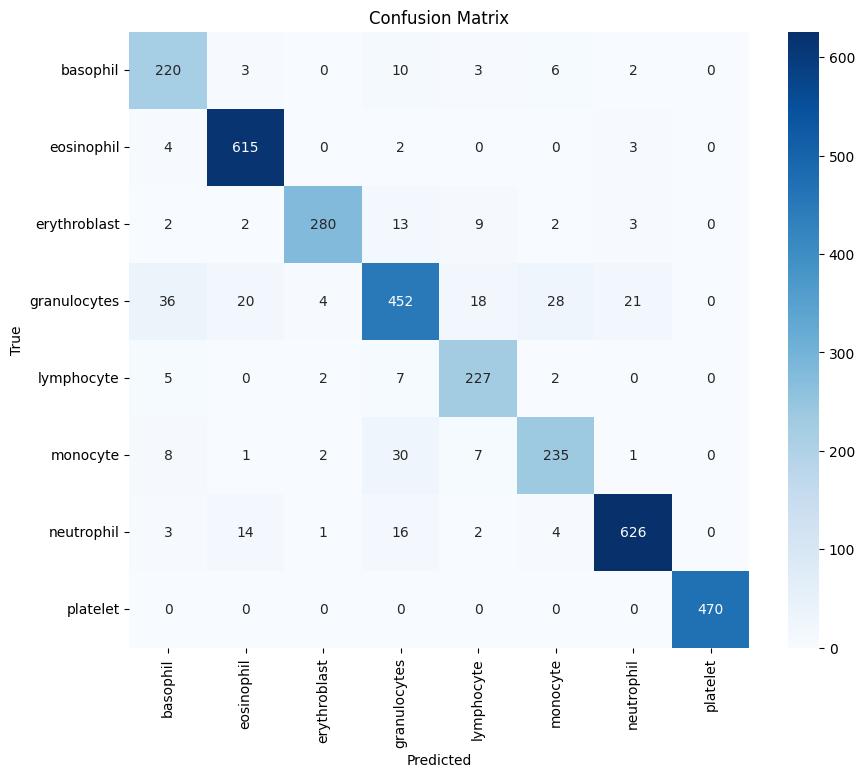

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to be 1D
        labels = labels.squeeze()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


    accuracy = 100 * correct / total
    print(f"Accuracy of the model on the {total} test images: {accuracy:.2f}%")

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.info['label'].values(), yticklabels=train_dataset.info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Calculate the memory size of the model
mem_size = 0
for param in model.parameters():
    mem_size += param.element_size() * param.nelement()

print(f"Memory size of the SimpleCNN model: {mem_size} bytes")

Memory size of the SimpleCNN model: 70560 bytes


In [29]:
import time

# Measure inference time on the test dataset
model.eval()
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time on the test dataset: {inference_time:.4f} seconds")

Inference time on the test dataset: 0.7017 seconds


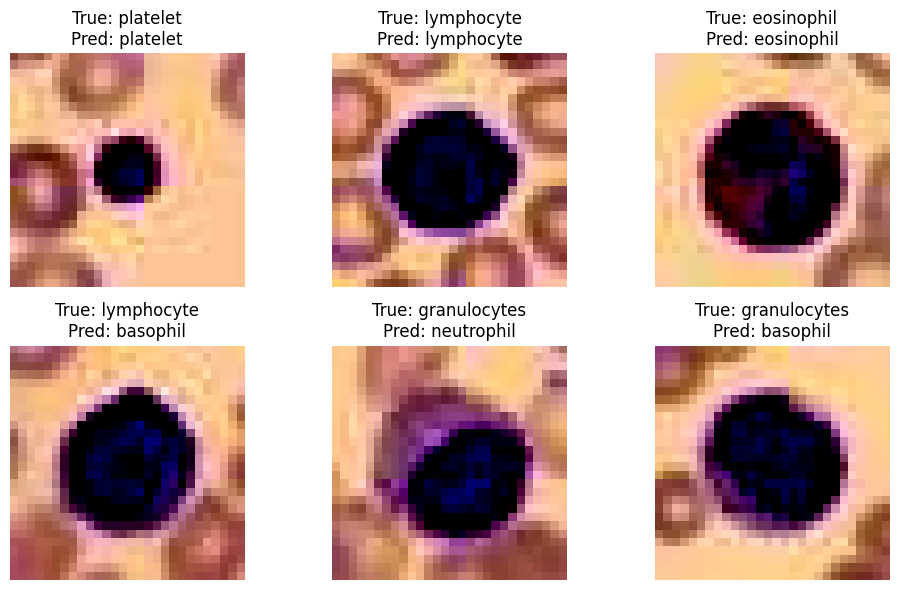

In [28]:
import random

# Evaluate the model on the test dataset and collect predictions
model.eval()
correct_samples = []
incorrect_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(images.size(0)):
            if predicted[i] == labels[i]:
                correct_samples.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))
            else:
                incorrect_samples.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

# Select 3 random correct and 3 random incorrect samples
num_samples_to_show = 3
random_correct = random.sample(correct_samples, min(num_samples_to_show, len(correct_samples)))
random_incorrect = random.sample(incorrect_samples, min(num_samples_to_show, len(incorrect_samples)))

# Display the selected samples
fig, axes = plt.subplots(2, num_samples_to_show, figsize=(10, 6))

# Display correct samples
for i in range(len(random_correct)):
    image, true_label, predicted_label = random_correct[i]
    axes[0, i].imshow(image.permute(1, 2, 0))
    axes[0, i].set_title(f"True: {train_dataset.info['label'][str(true_label.item())]}\nPred: {train_dataset.info['label'][str(predicted_label.item())]}")
    axes[0, i].axis('off')

# Display incorrect samples
for i in range(len(random_incorrect)):
    image, true_label, predicted_label = random_incorrect[i]
    axes[1, i].imshow(image.permute(1, 2, 0))
    axes[1, i].set_title(f"True: {train_dataset.info['label'][str(true_label.item())]}\nPred: {train_dataset.info['label'][str(predicted_label.item())]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()